In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize(0.5, 0.5) ## 픽셀 값을 0.5를 빼고 0.5로 나눠줍니다 --> tensor 범위 [-1,1]
])

train_dataset = datasets.MNIST(root='/home/pervinco/Datasets/MNIST', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='/home/pervinco/Datasets/MNIST', train=False, transform=transform, download=True)

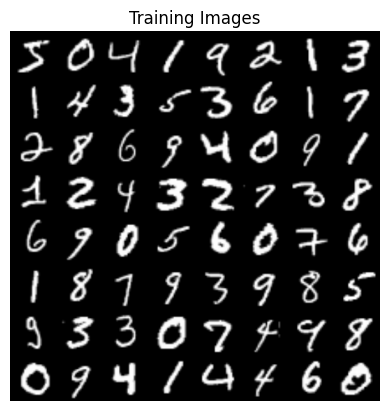

In [4]:
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

GAN은 생성자(Generator)와 판별자(Discriminator)로 구성됩니다. 생성자는 실제 데이터와 유사한 데이터를 생성하려고 하고, 분별자는 실제 데이터와 생성자가 생성해낸 데이터를 잘 구분하려고 합니다. **GAN의 목표는 판별자를 속이는 좋은 생성자를 찾아 실제 데이터와 유사한 샘플을 생성해내는 것입니다.**

> DCGAN의 생성자를 구현해봅니다.

GAN의 생성자는 잠재 벡터를 입력으로 받아 이미지를 출력합니다.

![](https://tutorials.pytorch.kr/_images/dcgan_generator.png)

위 그림은 [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)에서 64x64 크기의 이미지를 생성하기 위한 생성자 구조입니다. 기존 [Vanilla GANs](https://arxiv.org/pdf/1406.2661.pdf)에서는 풀링(Pooling)을 사용했는데 이를 합성곱 신경망으로 대체하였습니다. DCGAN에서 추천한 생성자 구조를 정리하면 아래와 같습니다.

* 풀링(Pooling) 레이어와 완전연결(Fully Connected) 레이어를 대체하여 전치 합성곱(Tranpose Convolution)을 사용하여 깊은 신경망을 구성한다.
* 전치 합성곱 레이어의 가중치를 평균 0, 표준편차 0.02인 정규분포로 초기화한다.
* 출력 전 레이어를 제외하고 배치 정규화(Batchnorm)을 사용한다.
* ReLU 활성화 함수를 사용한다. 마지막 출력을 위해서는 tanh 활성화 함수를 사용한다.

그림에서는 커널 크기가 5로 되어 있지만, pytorch에서는 커널 크기가 4일 때 크기를 2배로 만들 수 있습니다 ([ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) 참고).


❓ 처음에 잠재 벡터는 이미지가 아닌데 ConvTranspose2d 모듈을 사용하는 이유는?
> k차원 잠재 벡터 z를 채널이 k개인 1x1 크기 이미지로 생각합니다.

❓ ConvTranspose2d 모듈에서 bias=False로 지정하는 이유는?
> 배치 정규화를 사용하므로 해당 레이어의 bias는 의미 없어집니다.

In [ ]:
class Generator(nn.Module):
    def __init__(self,
                 latent_dim: int=64,
                 base_channels: int=64,
                 out_channels: int=1):

        # nn.Module의 __init__ 함수를 먼저 호출해줍니다
        super().__init__()

        self.model = nn.Sequential(
            # 입력: latent_dim x 1 x 1 크기
            nn.ConvTranspose2d(latent_dim, base_channels*8, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(base_channels*8), # 채널 단위로 정규화를 해줍니다
            nn.ReLU(inplace=True),
            # (base_channels*8) x 4 x 4 크기
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),
            # (base_channels*4) x 8 x 8 크기
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True),
            # (base_channels*2) x 16 x 16 크기
            nn.ConvTranspose2d(base_channels*2, base_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            # (base_channels) x 32 x 32 크기
            nn.ConvTranspose2d(base_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # 1 x 64 x 64 크기
        )

    def forward(self, z):
        return self.model(z)

> DCGAN의 판별자를 구현해봅니다.

판별자는 이미지를 입력으로 받아 진짜인지 가짜인지 판별합니다. 생성자에서와 반대로 합성곱 신경망으로 점차 이미지 크기를 줄여나갑니다. 마지막 레이어에서는 시그모이드 활성화 함수를 적용하여 [0,1] 범위의 입력 이미지가 실제 이미지일 확률을 출력합니다. [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) 논문에서 제안한 판별자의 구조는 아래와 같습니다.

* 합성곱(Convolution) 레이어만 사용하여 깊은 신경망을 구성한다.
* 입력 데이터에 연결된 레이어를 제외하고 배치 정규화(Batchnorm)을 적용한다.
* LeakyReLU 활성화 함수를 사용한다.

In [ ]:
"""
판별자
arguments:
    in_channels: 입력 이미지의 채널 개수
    base_channels: 합성곱 신경망의 기본 채널 크기
"""
class Discriminator(nn.Module):
    def __init__(self, in_channels: int=1, base_channels: int=64):
        super().__init__()

        self.model = nn.Sequential(
            # 입력: 1 x 64 x 64 크기
            nn.Conv2d(in_channels, base_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # base_channels x 32 x 32 크기
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2, inplace=True),
            # base_channels x 16 x 16 크기
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2, inplace=True),
            # base_channels x 8 x 8 크기
            nn.Conv2d(base_channels*4, base_channels*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2, inplace=True),
            # base_channels x 4 x 4 크기
            nn.Conv2d(base_channels*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

합성곱 레이어의 가중치를 초기화하는 함수를 작성합니다. 평균이 0이고 표준편차가 0.02인 정규 분포로부터 합성곱, 전치 합성곱 레이어의 초기 가중치를 설정합니다.

In [ ]:
"""
가중치 초기화 함수: 합성곱 또는 전치 합성곱 레이어에 대해 가중치를 평균 0, 표준편차 0.02인 정규분포에서 초기화
"""
def weights_init(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        nn.init.normal_(module.weight.data, 0.0, 0.02) # 가중치를 평균 0, 표준편차 0.02인 정규분포에서 초기화

```
💡 적대적 학습(Adversarial Training)을 구현하고 GAN의 손실함수를 어떻게 계산하는지 살펴봅니다.
```

📖 (복습) GAN의 손실 함수
$$
\min_{G}\max_{D} V(D, G) := \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_Z(z)}[\log (1 - D(G(z)))]
$$

손실 함수를 어떻게 계산할 수 있을까요?

📖 판별자의 손실 함수

먼저, 이진 분류에서의 크로스 엔트로피(Binary Cross Entropy) 손실함수를 생각해봅시다 ([pytorch 공식 문서 - BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#bceloss) 참고). 데이터 $x$와 레이블 $y$에 대해
$$
\ell = - [y \log x + (1 - y) \log (1 - x)] = \begin{cases}
    -\log x & y=1 \\
    -\log (1-x) & y=0
\end{cases}
$$
로 나타납니다 (앞에 $-$가 있음에 주의). 이를 활용하여 GAN의 손실 함수를 계산할 수 있습니다.

* 첫 번째 항: 실제 이미지 $x$에 대해 $D(x)$를 계산하고, 레이블이 1인 경우의 BCELoss를 계산합니다.
* 두 번쨰 항: 생성된 이미지 $G(z)$에 대해 $D(G(z))$를 계산하고, 레이블이 0인 경우의 BCELoss를 계산합니다.


📖 생성자의 손실 함수

먼저, 첫 번째 항은 생성자 G와 관련이 없습니다. 두 번째 항을 최소로 하는 과정에서 기울기 소멸 문제(Vanishing Gradient Problem)가 발생할 수 있습니다. 생성자는 판별자가 가짜라고 판단한(= D(G(x))가 0에 가까운) 경우에 대해 그래디언트가 크게 계산되어 판별자를 속이려는 방향으로 학습하는 경향이 바람직한데 $\log (1-x)$의 경우 0 근방에서 접선의 기울기가 0에 가깝게 됩니다. 이를 개선하여 생성자의 손실 함수는 최종적으로
$$
\mathbb{E}_{z \sim p_Z(z)}[- \log D(G(z))]
$$
가 됩니다. 여기서 $- \log x$는 0 근방에서 접선의 기울기가 크고, 1 근방에서 접선의 기울기가 작습니다. 구현은 판별자의 손실 함수의 첫 번째 항과 비슷하게 생성된 이미지 $G(x)$에 대해 $D(G(x))$를 계산하고 레이블이 1인 경우의 BCELoss를 계산합니다.

In [ ]:
os.makedirs("results", exist_ok = True)

base_channels = 64 # 생성자, 판별자 구조의 기본 채널 수
batch_size = 128
num_epochs = 20
latent_dim = 32 # 잠재 벡터 차원

lr = 0.0002 # 생성자의 학습률(learning rate)
lr_adv = 0.0002 # 판별자의 학습률
beta1 = 0.5 # Adam optimizer의 beta1 파라미터 값

# Dataloader 정의
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)

1. z를 정규분포에서 샘플링한다.
1. 생성 이미지 $G(z)$를 계산한다.
1. 판별자의 손실 함수를 계산하고 판별자를 최적화한다.
1. 생성자의 손실 함수를 게산하고 생성자를 최적화한다.

판별자와 생성자를 학습할 때 모두 생성자의 출력 이미지 $G(z)$가 사용됩니다. 판별자를 먼저 학습할 때 [`torch.detach`](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html) 함수를 사용하여 생성자에 대해 역전파가 일어나지 않도록 그래디언트를 계산하지 않도록 해야 합니다. `detach` 함수는 입력 텐서의 `requires_grad` 옵션을 False로 만들어줍니다. 아래 코드에서 `fake_prob = discriminator(fake_data.detach())`와 같이 디코더의 출력 `fake_data`에 detach 함수를 적용해주면 그래디언트가 계산되지 않게 됩니다. `detach` 함수를 사용하지 않는다면 생성자의 손실함수의 backward 과정에서 "Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed)."와 같은 에러 메시지가 뜨게 됩니다. 이는 판별자의 손실 함수로부터 그래디언트를 계산할 때 생성자에 대한 그래디언트가 이미 계산되어 생성자를 업데이트하려고 할 때 오류가 발생하는 것입니다.

In [ ]:
# 생성자 & 판별자 모형
generator = Generator(latent_dim, out_channels=1, base_channels=base_channels).to(device)
discriminator = Discriminator(in_channels=1, base_channels=base_channels).to(device)
generator.apply(weights_init) # 가중치 초기화 적용
discriminator.apply(weights_init) # 가중치 초기화 적용

# 최적화기 설정
optim_g = optim.Adam(generator.parameters(), lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr_adv, betas=(beta1, 0.999))

# 이진 교차 엔트로피 정의
criterion = nn.BCELoss()

In [ ]:
# 학습 과정 (20분+)

# epoch 단위로 loss 평균을 기록할 리스트
train_loss_g_epoch, train_loss_d_epoch = [], []
val_loss_g_epoch, val_loss_d_epoch = [], []

fixed_z = torch.randn((64, latent_dim, 1, 1), device=device) # 64개의 고정된 잠재 벡터 (생성할 때 사용됨)

for epoch in range(1, num_epochs+1):
    total_loss_g, total_loss_d = 0., 0. # iteration마다 손실 함수의 누적합
    total_num_data = 0 # 1 epoch에 사용된 데이터 수

    generator.train() # 훈련 모드로 변환: 배치 정규화에서 평균, 표준편차를 기록함
    discriminator.train() # 훈련 모드로 변환: 배치 정규화에서 평균, 표준편차를 기록함

    # train
    for i, data in enumerate(train_loader):
        real_data = data[0].to(device) # 실제 이미지 (인덱스 0: 이미지 / 1: 숫자 레이블)
        num_data = real_data.size(0) # 배치 크기
        total_num_data += num_data # 배치 크기 누적합

        # 잠재 벡터 샘플링과 이미지 생성
        sample_z = torch.randn((num_data, latent_dim, 1, 1), device=device) # 표준정규분포에서 잠재 벡터 샘플링
        fake_data = generator(sample_z) # 이미지 생성 (판별자 입장에서 가짜 이미지)

        # BCELoss 계산을 위한 레이블 (real_label: 모두 1, fake_label: 모두 0)
        real_label = torch.ones(num_data, device=device)
        fake_label = torch.zeros(num_data, device=device)

        # 판별자 학습
        # detach() --> fake_data 이전으로는 역전파 그래디언트를 계산하지 않음
        #          --> 생성자 파라미터는 그래디언트 = 0
        real_prob = discriminator(real_data).view(-1) # D(x) 계산하여 1차원 벡터로 변환
        fake_prob = discriminator(fake_data.detach()).view(-1) # D(G(z)) 계산하여 1차원 벡터로 변환
        optim_d.zero_grad()
        # 판별자 손실 함수 계산
        #     첫 번째 항: 확률 D(x), 레이블 1일 때의 bceloss = - log D(x)
        #     두 번째 항: 확률 D(G(z)), 레이블 0일 때의 bceloss = - log (1 - D(G(z)))
        loss_d = criterion(real_prob, real_label) + criterion(fake_prob, fake_label)
        loss_d.backward()
        optim_d.step() # 판별자 업데이트

        total_loss_d += loss_d.item() * num_data # 판별자 손실 함수 누적합

        # 생성자 학습
        # detach() 제외 --> 생성자 파라미터에 대해 역전파 그래디언트 계산 --> 생성자 학습
        fake_prob = discriminator(fake_data).view(-1) # D(G(z)) 계산하여 1차원 벡터로 변환

        optim_g.zero_grad()
        # 생성자 손실 함수 계산
        #     확률 D(G(z)), 레이블 1일 때의 bceloss = - log D(G(z))
        loss_g = criterion(fake_prob, real_label)
        loss_g.backward()
        optim_g.step()

        total_loss_g += loss_g.item() * num_data # 생성자 손실 함수 누적합

    # 에폭 단위 평균 손실 함수 기록
    train_loss_g_epoch.append(total_loss_g / total_num_data)
    train_loss_d_epoch.append(total_loss_d / total_num_data)

    # validation
    val_total_loss_g, val_total_loss_d = 0., 0. # iteration마다 손실 함수의 누적합
    val_total_num_data = 0 # 1 epoch에 사용된 데이터 수

    generator.eval() # 검증 모드로 변환: 배치 정규화에서 평균, 표준편차를 기록하지 않음
    discriminator.eval() # 검증 모드로 변환: 배치 정규화에서 평균, 표준편차를 기록하지 않음

    for data in test_loader:
        real_data = data[0].to(device) # 실제 이미지 (인덱스 0: 이미지 / 1: 숫자 레이블)
        num_data = real_data.size(0) # 배치 크기
        val_total_num_data += num_data # 배치 크기 누적합

        with torch.no_grad(): # 그래디언트 계산 X
            # 잠재 벡터 샘플링과 이미지 생성
            sample_z = torch.randn((num_data, latent_dim, 1, 1), device=device) # 표준정규분포에서 잠재 벡터 샘플링
            fake_data = generator(sample_z) # 이미지 생성 (판별자 입장에서 가짜 이미지)

            # BCELoss 계산을 위한 레이블 (real_label: 모두 1, fake_label: 모두 0)
            real_label = torch.ones(num_data, device=device)
            fake_label = torch.zeros(num_data, device=device)

            # 판별자 손실 함수
            real_prob = discriminator(real_data).view(-1)
            fake_prob = discriminator(fake_data.detach()).view(-1)
            loss_d = criterion(real_prob, real_label) + criterion(fake_prob, fake_label) # 판별자 손실 함수 계산
            val_total_loss_d += loss_d.item() * num_data # 판별자 손실 함수 누적합

            # 생성자 손실 함수
            fake_prob = discriminator(fake_data).view(-1)
            loss_g = criterion(fake_prob, real_label) # 생성자 손실 함수 계산
            val_total_loss_g += loss_g.item() * num_data # 생성자 손실 함수 누적합

    # 64개의 고정된 잠재 벡터에 대한 생성 결과를 results 폴더에 저장
    plt.axis('off')
    plt.title("Generated samples")
    plt.imshow(np.transpose(utils.make_grid(generator(fixed_z).detach().cpu(), normalize=True), (1,2,0)))
    plt.savefig(f'results/gen_epoch{epoch}.png')

    val_loss_g_epoch.append(val_total_loss_g / val_total_num_data)
    val_loss_d_epoch.append(val_total_loss_d / val_total_num_data)

    # 손실 함수 출력
    # f-string 02d 옵션: 2자리 정수 출력 / 1.4f 옵션: 정수 부분 1자리, 소수 부분 4자리 출력
    print(
        f"[{epoch:02d}/{num_epochs:02d}] loss_d: {total_loss_d / total_num_data:1.4f}\tloss_g: {total_loss_g / total_num_data:1.4f}" \
        + f"\tval_loss_d: {val_total_loss_d / val_total_num_data:1.4f}\tval_loss_g: {val_total_loss_g / val_total_num_data:1.4f}"
    )

In [ ]:
plt.figure(figsize=(10,4)) # 그림판 크기 조절
plt.subplot(121) # 121 = 1행 2열 그림 중 첫 번째 그림
plt.title("Discriminator loss") # 판별자 손실 함수 그래프
plt.plot(train_loss_d_epoch, label="train")
plt.plot(val_loss_d_epoch, label="valid")
plt.legend()

plt.subplot(122) # 122 = 1행 2열 그림 중 두 번째 그림
plt.title("Generator loss") # 생성자 손실 함수 그래프
plt.plot(train_loss_g_epoch, label="train")
plt.plot(val_loss_g_epoch, label="valid")
plt.legend()

plt.show()

## 생성 모델 평가: Inception Score

```
💡 Inception Score(IS)를 계산하여 생성 모델을 평가해봅니다.
```

IS 계산 절차:

1. MNIST 숫자 분류기 학습
1. 생성 이미지를 분류
1. IS 계산

Inception Score(이하 IS)는 예리함(Sharpness)과 다양성(Diversity)의 곱으로 계산됩니다. 여기서, 예리함은 숫자를 명확히 생성하여 분류기가 해당 숫자를 잘 예측하는 것을 의미하고 다양성은 다양한 숫자를 생성하는 것을 뜻합니다. IS는 생성 이미지만 이용하여 계산하며 먼저 분류기를 통해 어떤 숫자 이미지인지 분류합니다. 전체 생성 이미지들이 0~9 숫자를 어떤 비율로 생성됐는지 계산하고(=$q(y)$) 이를 기준으로 생성 이미지의 숫자 분류 확률(=$q(y|x)$)와 쿨백-라이블러 거리를 계산하게 됩니다.
$$
\begin{aligned}
IS &= \exp (\mathbb{E}_{x \sim p_{\theta}(x)}KL(q(y|x) \Vert q(y)) \\
&= \exp \left( \mathbb{E}_{x \sim p_{\theta}(x)} \sum_{y} \big[ q(y|x) \log q(y|x) - q(y|x) \log q(y) \big] \right)
\end{aligned}
$$

Inception Score는 사전훈련된 Inception-V3 모델을 분류기를 활용하여 계산하지만 본 실습에서는 MNIST 숫자 분류기를 학습하여 IS를 계산합니다.

In [ ]:
# 선형 레이어를 쌓은 숫자 분류기를 만듭니다
digits_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(4096, 256),
    nn.Dropout(p=0.2, inplace=True),
    nn.ReLU(inplace=True),
    nn.Linear(256, 256),
    nn.Dropout(p=0.2, inplace=True),
    nn.ReLU(inplace=True),
    nn.Linear(256, 10)
).to(device)

# RMSProp 최적화기를 설정합니다
optim_clf = optim.RMSprop(digits_classifier.parameters(), lr=5e-4)

# 크로스 엔트로피 손실 함수를 정의합니다.
ce = nn.CrossEntropyLoss()

for epoch in range(10):
    total_loss = 0. # 에폭 단위 손실 함수 누적합
    # num_data: 에폭 단위 데이터 수 / num_correct: 에폭 단위 레이블을 맞춘 데이터 수
    num_data, num_correct = 0, 0

    digits_classifier.train() # 학습 모드: Dropout 활성화

    # train
    for data in train_loader:
        image = data[0].to(device)
        label = data[1].to(device)

        logits = digits_classifier(image) # 로짓 계산
        optim_clf.zero_grad()
        loss = ce(logits, label.long()) # 크로스 엔트로피 게산
        loss.backward()
        optim_clf.step() # 분류기 학습

        total_loss += loss.item() * len(label) # 손실 함수 누적합
        num_data += len(label) # 데이터 수 누적합
        # 레이블 맞춘 데이터 수 누적합
        #     logits.argmax(dim=1): 10차원 분류기 출력 중 가장 로짓이 큰 인덱스로 예측 레이블 계산
        num_correct += (logits.argmax(dim=1) == label).sum().item()


    val_total_loss = 0. # 에폭 단위 손실 함수 누적합
    # num_data: 에폭 단위 데이터 수 / num_correct: 에폭 단위 레이블을 맞춘 데이터 수
    val_num_data, val_num_correct = 0, 0

    digits_classifier.eval() # 검증 모드: Dropout 비활성화

    for data in test_loader:
        image = data[0].to(device)
        label = data[1].to(device)

        logits = digits_classifier(image)
        val_loss = ce(logits, label.long()) # 손실함수 계산

        # 손실함수, 데이터 수, 레이블 맞춘 데이터 수 누적합 계산
        val_total_loss += val_loss.item() * len(label)
        val_num_data += len(label)
        val_num_correct += (logits.argmax(dim=1) == label).sum().item()

    # 손실 함수, 예측 정확도 출력
    print(
        f"[{epoch+1:02d}/10] loss: {total_loss / num_data:1.6f}\taccuracy: {num_correct / num_data:1.6f}" \
        +f"\tval_loss: {val_total_loss / val_num_data:1.6f}\tval_accuracy: {val_num_correct / val_num_data:1.6f}"
    )

[01/10] loss: 0.507963	accuracy: 0.856450	val_loss: 0.247519	val_accuracy: 0.921800
[02/10] loss: 0.229859	accuracy: 0.929383	val_loss: 0.184883	val_accuracy: 0.940100
[03/10] loss: 0.180052	accuracy: 0.945267	val_loss: 0.129459	val_accuracy: 0.961500
[04/10] loss: 0.156070	accuracy: 0.951583	val_loss: 0.098400	val_accuracy: 0.969600
[05/10] loss: 0.135461	accuracy: 0.957650	val_loss: 0.111889	val_accuracy: 0.965000
[06/10] loss: 0.124011	accuracy: 0.960883	val_loss: 0.076089	val_accuracy: 0.975600
[07/10] loss: 0.116138	accuracy: 0.964117	val_loss: 0.077362	val_accuracy: 0.974900
[08/10] loss: 0.108056	accuracy: 0.966100	val_loss: 0.088269	val_accuracy: 0.970500
[09/10] loss: 0.102581	accuracy: 0.967450	val_loss: 0.081485	val_accuracy: 0.973900
[10/10] loss: 0.097379	accuracy: 0.969483	val_loss: 0.073344	val_accuracy: 0.975900


학습된 숫자 분류기의 예측 정확도는 97% 이상입니다. 이제 5만개의 이미지를 생성하고 Inception score를 계산합니다. 생성 이미지들의 레이블 분포 $q(y)$는 5만개 생성 이미지에 대해 $q(y|x)$를 평균내어 계산합니다.


In [ ]:
num_samples = 10000

# 생성자와 숫자 분류기 검증 모드로 전환
generator.eval()
digits_classifier.eval()

# 5만개 이미지 생성
gen_images = generator(torch.randn((num_samples, latent_dim, 1, 1), device="cuda"))

생성한 이미지를 시각화해봅니다.

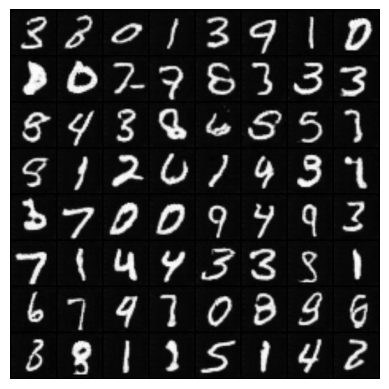

In [ ]:
plt.axis('off')
plt.imshow(np.transpose(utils.make_grid(gen_images[0:64].cpu(), normalize=True),(1,2,0)))

선명한 숫자들이 생성된것을 확인할 수 있습니다.

In [ ]:
# 예측 확률 계산 (softmax를 적용해 로짓을 확률로 변환)
y_pred = torch.softmax(digits_classifier(gen_images.cuda()), dim=1).detach().cpu() # 50000 x 10 차원
q_y = y_pred.mean(dim = 0) # q(y) 계산: 각 생성 이미지의 예측 확률의 평균 # 1 x 10차원

# Inception score 계산:
#     IS의 첫 번째 항을 계산하려면 먼저 각 이미지(x)에 대해 q(y|x) log q(y|x)를 모든 y(0~9)에 대해 합쳐야 하므로
#     .sum(dim=1) 함수를 이용하여 두 번째 차원에 대해 합을 먼저 계산합니다.
#     이후 모든 x에 대해 평균을 취해주면 됩니다.
log_is = (y_pred * y_pred.log()).sum(dim=1).mean() - (y_pred * q_y.log()).sum(dim=1).mean()
print("IS score:", log_is.exp().item())

IS score: 7.729973793029785


- (참고) [torchmetric.image.inception.InceptionScore](https://torchmetrics.readthedocs.io/en/stable/image/inception_score.html) : `torchmetrics` 패키지를 이용하면 Inception-V3 모델을 분류기로 활용한 Inception Score를 쉽게 계산할 수 있습니다.